# Library Imports

In [59]:
# Import necessary libraries
from dotenv import load_dotenv
import os

load_dotenv()

# Get environment variables as strings
llm_api_key = os.getenv('GROQ_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="pr-downright-hacienda-56"
from typing import TypedDict, List, Annotated, Literal
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_community.document_loaders import (
    PyPDFLoader,
    Docx2txtLoader, 
    UnstructuredPowerPointLoader, 
    CSVLoader, 
    UnstructuredExcelLoader
)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
import chromadb
from langchain_huggingface import HuggingFaceEmbeddings
import pandas as pd
from langchain.agents import AgentExecutor, create_tool_calling_agent
from pathlib import Path
from typing import List, Dict, Optional, Type, Any
from IPython.display import Image, display
from llm import get_llama_3dot3_70b_versatile,get_llama_3dot1_8b_instant,get_70b_8192, get_llama3_8b_8192,DeepSeek
#llm = get_llama_3dot3_70b_versatile()
llm = get_llama_3dot1_8b_instant()
non_tool_llm=get_llama3_8b_8192()
player_metrics_llm = get_llama_3dot1_8b_instant()
pandasllm = get_llama_3dot1_8b_instant()
deepseek_llm = DeepSeek()
deepseek_llm = get_llama_3dot3_70b_versatile()
extraction_llm = get_llama_3dot1_8b_instant()

# Set-Up And Test Vector Store

In [60]:
# initialise and set our vector database
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
client = chromadb.PersistentClient(path=".\LLM\Guided_langchain\chroma_db")
vectorstore = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name="my_collection"
)
CHROMA_PATH = "./LLM/Guided_langchain/chroma_db"

def load_and_split_document(file_path: str) -> List[Document]:
    """Load and split a document into chunks."""
    if file_path.endswith('.pdf'):
        loader = PyPDFLoader(file_path)
    elif file_path.endswith('.docx'):
        loader = Docx2txtLoader(file_path)
    elif file_path.endswith(('.ppt', '.pptx')):
        loader = UnstructuredPowerPointLoader(file_path, mode="elements")
    elif file_path.endswith(('.xls', '.xlsx')):
        loader = UnstructuredExcelLoader(file_path)
    elif file_path.endswith('.csv'):
        loader = CSVLoader(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

    documents = loader.load()
    return text_splitter.split_documents(documents)

def get_vectorstore():
    """Get or create vectorstore with fresh client connection."""
    os.makedirs(CHROMA_PATH, exist_ok=True)
    client = chromadb.PersistentClient(path=CHROMA_PATH)
    return Chroma(
        client=client,
        embedding_function=embedding_function,
        collection_name="my_collection"
    )

def verify_document_loading(file_path: str):
    """Load, index, and verify document loading with detailed debugging."""
    print("\nSTEP 1: Loading document...")
    try:
        splits = load_and_split_document(file_path)
        print(f"Successfully split document into {len(splits)} chunks")
        print("\nFirst chunk preview:")
        if splits:
            print(splits[0].page_content[:200])
        
        print("\nSTEP 2: Resetting collection...")
        # Get fresh vectorstore connection
        vectorstore = get_vectorstore()
        
        # Get and delete existing documents
        existing_ids = vectorstore._collection.get()['ids']
        if existing_ids:
            vectorstore._collection.delete(ids=existing_ids)
        print("Collection reset complete")
        
        print("\nSTEP 3: Indexing document chunks...")
        for i, split in enumerate(splits):
            split.metadata['file_id'] = 1
            split.metadata['chunk_id'] = i
        
        vectorstore.add_documents(splits)
        print(f"Added {len(splits)} chunks to vectorstore")
        return True
    except Exception as e:
        print(f"ERROR during document processing: {str(e)}")
        import traceback
        traceback.print_exc()
        return False
    
file_path = r"C:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\data\multi_session_hias\Research Paper.docx"
# vecstore = verify_document_loading(file_path)
# retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})
# retriever.invoke("How many athletes were in the study?")#,ConsistencyLevel="LOCAL_ONE")

# Session Data Loader And Class

In [61]:
from preprocess_df import full_preprocess
from poc_tools import ComparePlayerSessionsDictionary


def load_session_data(data_directory: str) -> Dict[str, pd.DataFrame]:
    """
    Load multiple session CSV files from a directory.
    
    Args:
        data_directory (str): Path to directory containing session CSV files
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary of DataFrames with session dates as keys
    """
    session_data = {}
    data_path = Path(data_directory)
    
    for csv_file in data_path.glob("*.csv"):
        # Extract date from filename (assuming format includes date)
        # Modify this based on your actual filename format
        date_str = csv_file.stem.split(" ")[0]  # Adjust splitting logic as needed
        
        # Load and preprocess the DataFrame
        df = pd.read_csv(csv_file)
        df = full_preprocess(df)  # Your preprocessing function
        
        session_data[date_str] = df
    
    return session_data

# Load session data
data_directory = r"C:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\data\multi_session_hias"
session_data = load_session_data(data_directory)

Preprocessing completed successfully
Preprocessing completed successfully
Preprocessing completed successfully


In [62]:
list(session_data.values())[0]

,Date,Calculated Start Time,Player,High Intensity Activity Type,Time Since Last Any Action,Start Time,End Time,Time Since Last,Duration,Distance,Magnitude,Avg Metabolic Power,Dynamic Stress Load
0,2025-01-12,2025-01-12 08:56:03.000,ruairi,Acceleration,None,2025-01-12 08:56:03,2025-01-12 08:56:04,00:02.8,1.0,0.89,3.64,23.30,0.03
1,2025-01-12,2025-01-12 08:56:13.200,colly,Acceleration,00:09.2,2025-01-12 08:56:14,2025-01-12 08:56:14,00:03.1,0.8,0.86,5.10,96.38,0.02
2,2025-01-12,2025-01-12 08:56:14.300,colly,Deceleration,00:00.3,2025-01-12 08:56:15,2025-01-12 08:56:15,00:06.6,0.7,0.75,4.60,8.45,0.00
3,2025-01-12,2025-01-12 08:57:21.100,decky b,Acceleration,01:06.1,2025-01-12 08:57:21,2025-01-12 08:57:22,00:11.2,0.9,0.83,3.29,34.34,0.00
4,2025-01-12,2025-01-12 08:58:57.600,ethan,Acceleration,01:35.6,2025-01-12 08:58:57,2025-01-12 08:59:00,00:02.8,2.4,7.33,3.02,35.55,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,2025-01-12,2025-01-12 12:14:01.500,ruairi,Acceleration,00:03.5,2025-01-12 12:14:02,2025-01-12 12:14:04,00:06.2,2.5,2.85,5.77,7.49,0.00
3641,2025-01-12,2025-01-12 12:14:02.100,jmce,Deceleration,-1:58.1,2025-01-12 12:14:02,2025-01-12 12:14:04,00:01.7,1.9,0.88,3.30,7.36,0.00
3642,2025-01-12,2025-01-12 12:14:09.000,ruairi,Acceleration,00:05.0,2025-01-12 12:14:09,2025-01-12 12:14:10,00:04.9,1.0,2.66,3.14,50.84,0.00
3643,2025-01-12,2025-01-12 12:14:22.400,kolo,Sprint,00:12.4,2025-01-12 12:14:22,2025-01-12 12:14:26,02:06.5,3.6,36.45,11.50,49.35,0.00


# Custom Agents

## Vector Store Information Parser
- note this one is just a similarity search so up here we will only work on its prompt

In [63]:


vector_database_information_analysis_prompt = """
You have been given the most similar documents based on a vector database search.

Taking the user's question into account alongside the documents returned from the database,
you should review and organise the research findings most relevant to the user's initial query.
Present the findings in a clear, digestable format that would be helful for sports science practitioners.

Always use british spellings.

RESEARCH FINDINGS:
{research}

USER QUESTION :
{context}

P.s. don't add any fluff. only include the elements that would directly answer the question the user provided.

P.P.S Focus on comparing the player's metrics against the research metrics rather than segmenting the two. Do not first show the player metrics then the research metrics. I want you to immediately show them in comparison to each other.
"""

## General Player Metrics Agent

In [64]:


'''
# prompt = ChatPromptTemplate.from_messages([
#     (
#         "system",
#         """You are a sports performance analyst assistant specialising in analysing 
#         player metrics across different training sessions.
        
#         Your role is to use the compare_player_sessions_dict tool which returns metrics 
#         for each session a player participated in.
        
#         Process:
#         1. Extract the player name from the user's input
#         2. Use the compare_player_sessions_dict tool to retrieve their data
#         3. Return ONLY the dictionary output from the tool
        
#         The tool handles:
#         - Activity type distributions
#         - Performance metrics (Duration, Distance, Magnitude)
#         - Metabolic power and stress loads
#         - Time-based patterns
#         - Trend analysis (for multiple sessions)
        
#         CRITICAL INSTRUCTIONS:
#         - Return ONLY the Python dictionary output
#         - Do NOT add any explanatory text
#         - Do NOT format or modify the dictionary
#         - Do NOT add any commentary or analysis
#         - The tool's output is already properly formatted
        
#         Example correct output:
#         {"player_name": "John", "total_sessions": 1, "metrics_by_date": {...}}
#         """
#     ),
#     ("placeholder", "{chat_history}"),
#     ("human", "{input}"),
#     ("placeholder", "{agent_scratchpad}"),
# ])

# player_metric_agent = create_tool_calling_agent(
#     llm=player_metrics_llm,
#     tools=[metrics_comparison_tool],
#     prompt=prompt
# )

# # Create the agent executor
# agent_executor = AgentExecutor(
#     agent=player_metric_agent,
#     tools=[metrics_comparison_tool],
#     verbose=True
# )

# x = agent_executor.invoke({
#     "input": "analyse Lee's performance across all available sessions and provide his metrics as a dictionary"
# })'''

from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder

metrics_comparison_tool = ComparePlayerSessionsDictionary(session_data=session_data)
# Create the system and human message templates
system_message = SystemMessagePromptTemplate.from_template(
    """You are a sports performance analyst assistant specialising in analysing 
    player metrics across different training sessions.
    
    Your role is to use the compare_player_sessions_dict tool to return player metrics.
    When you receive an input, extract the player name and use the tool with that name.
    
    You MUST:
    1. Extract the player name from the input
    2. Use compare_player_sessions_dict with the extracted name
    3. Return ONLY the tool's output dictionary
    
    DO NOT add any text before or after the dictionary."""
)

human_message = HumanMessagePromptTemplate.from_template("{input}")

# Create the chat prompt from the messages
prompt = ChatPromptTemplate.from_messages([
    system_message,
    human_message,
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

# Initialize your tool
metrics_comparison_tool = ComparePlayerSessionsDictionary(session_data=session_data)

# Create the agent
player_metric_agent = create_tool_calling_agent(
    llm=player_metrics_llm,
    tools=[metrics_comparison_tool],
    prompt=prompt
)

# Create the agent executor
agent_executor = AgentExecutor(
    agent=player_metric_agent,
    tools=[metrics_comparison_tool],
    verbose=True
)

# Run the agent
x = agent_executor.invoke({
    "input": "analyse Kolo's performance across all available sessions and provide his metrics as a dictionary"
})



> Entering new AgentExecutor chain...

Invoking: `compare_player_sessions_dict` with `{'player_name': 'Kolo'}`


{'player_name': 'Kolo', 'total_sessions': 3, 'sessions': {'2025-01-12-16': {'player_metrics': {'Duration': {'mean': 13.685844748858447, 'min': 0.4, 'max': 823.9, 'std': 72.80598782332339, 'count': 219}, 'Distance': {'mean': 142.2605936073059, 'min': 0.0, 'max': 9408.13, 'std': 834.2689734210118, 'count': 219}, 'Magnitude': {'mean': 6.248949771689498, 'min': 3.01, 'max': 11.5, 'std': 3.223753907936125, 'count': 219}, 'Avg Metabolic Power': {'mean': 118.44374429223744, 'min': 0.16, 'max': 10434.69, 'std': 708.4555344159799, 'count': 219}, 'Dynamic Stress Load': {'mean': 0.11319634703196346, 'min': 0.0, 'max': 5.37, 'std': 0.39760961535798744, 'count': 219}}, 'Activity_Distribution': {'Acceleration': 42.465753424657535, 'Deceleration': 31.506849315068493, 'Sprint': 26.027397260273972}, 'Time_Metrics': {'avg_time_between_actions': '01:48.87', 'min_time_between_actions': '00:00

# Plain Player Metrics

In [65]:
from poc_tools import PlayerSessionMetricsInput, SingleSessionPlayerMetrics
# Initialize the tool
single_session_metrics = SingleSessionPlayerMetrics(session_data=session_data)

# Use it with a specific date
result_with_date = single_session_metrics.run({
    "player_name": "Lee",
    "session_date": "2024-01-15"  # Specific date
})

# Or use it without a date (will return latest session)
result_latest = single_session_metrics.run({
    "player_name": "Lee"
})
result_latest

{'player_name': 'Lee',
 'session_date': '2025-01-17-24',
 'metrics': {'player_metrics': {'Duration': {'mean': 1.9452702702702702,
    'min': 0.7,
    'max': 4.2,
    'std': 0.7416963879507882,
    'count': 148},
   'Distance': {'mean': 6.405405405405405,
    'min': 0.36,
    'max': 21.21,
    'std': 4.574265396340822,
    'count': 148},
   'Magnitude': {'mean': 3.984121621621621,
    'min': 3.0,
    'max': 5.62,
    'std': 0.7037440484919418,
    'count': 148},
   'Avg Metabolic Power': {'mean': 43.192635135135134,
    'min': 2.41,
    'max': 156.06,
    'std': 24.524950071346165,
    'count': 148},
   'Dynamic Stress Load': {'mean': 0.4142567567567567,
    'min': 0.0,
    'max': 2.11,
    'std': 0.4290173730941682,
    'count': 148}},
  'Activity_Distribution': {'Acceleration': 57.432432432432435,
   'Deceleration': 42.567567567567565},
  'Time_Metrics': {'avg_time_between_actions': '01:28.39',
   'min_time_between_actions': '00:00.00',
   'max_time_between_actions': '01:59.90'},
  't

In [66]:
# Create the prompt template with only the required variables
single_session_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a sports performance analyst assistant specialising in analysing 
        player metrics from individual training sessions.
        
        Your role is to use the get_player_session_metrics tool which returns metrics
        for a player's specific session or their latest session if no date is specified.
        
        When analysing a player's session:
        1. Extract the player name from the user's query
        2. Check if a specific date is mentioned in the query
        3. Use get_player_session_metrics tool to get their data
        4. Return ONLY the dictionary output
        
        The tool handles:
        - Activity type distributions
        - Performance metrics (Duration, Distance, Magnitude)
        - Metabolic power and stress loads
        - Time-based metrics
        
        CRITICAL: Return ONLY the Python dictionary output, with no additional text.
        """
    ),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

# Initialize the tool
single_session_metrics = SingleSessionPlayerMetrics(session_data=session_data)

# Create the agent
single_session_agent = create_tool_calling_agent(
    llm=llm,
    tools=[single_session_metrics],
    prompt=single_session_prompt
)

# Create the agent executor
single_session_executor = AgentExecutor(
    agent=single_session_agent,
    tools=[single_session_metrics],
    verbose=True
)

# Test invocation
result = single_session_executor.invoke({
    "input": "get Lee's performance metrics"
})['output']
result



> Entering new AgentExecutor chain...

Invoking: `get_player_session_metrics` with `{'player_name': 'Lee', 'session_date': None}`


{'player_name': 'Lee', 'session_date': '2025-01-17-24', 'metrics': {'player_metrics': {'Duration': {'mean': 1.9452702702702702, 'min': 0.7, 'max': 4.2, 'std': 0.7416963879507882, 'count': 148}, 'Distance': {'mean': 6.405405405405405, 'min': 0.36, 'max': 21.21, 'std': 4.574265396340822, 'count': 148}, 'Magnitude': {'mean': 3.984121621621621, 'min': 3.0, 'max': 5.62, 'std': 0.7037440484919418, 'count': 148}, 'Avg Metabolic Power': {'mean': 43.192635135135134, 'min': 2.41, 'max': 156.06, 'std': 24.524950071346165, 'count': 148}, 'Dynamic Stress Load': {'mean': 0.4142567567567567, 'min': 0.0, 'max': 2.11, 'std': 0.4290173730941682, 'count': 148}}, 'Activity_Distribution': {'Acceleration': 57.432432432432435, 'Deceleration': 42.567567567567565}, 'Time_Metrics': {'avg_time_between_actions': '01:28.39', 'min_time_between_actions': '00:00.00', 'max_time_between_

{'player_name': 'Lee',
 'session_date': '2025-01-17-24',
 'metrics': {'player_metrics': {'Duration': {'mean': 1.9452702702702702,
    'min': 0.7,
    'max': 4.2,
    'std': 0.7416963879507882,
    'count': 148},
   'Distance': {'mean': 6.405405405405405,
    'min': 0.36,
    'max': 21.21,
    'std': 4.574265396340822,
    'count': 148},
   'Magnitude': {'mean': 3.984121621621621,
    'min': 3.0,
    'max': 5.62,
    'std': 0.7037440484919418,
    'count': 148},
   'Avg Metabolic Power': {'mean': 43.192635135135134,
    'min': 2.41,
    'max': 156.06,
    'std': 24.524950071346165,
    'count': 148},
   'Dynamic Stress Load': {'mean': 0.4142567567567567,
    'min': 0.0,
    'max': 2.11,
    'std': 0.4290173730941682,
    'count': 148}},
  'Activity_Distribution': {'Acceleration': 57.432432432432435,
   'Deceleration': 42.567567567567565},
  'Time_Metrics': {'avg_time_between_actions': '01:28.39',
   'min_time_between_actions': '00:00.00',
   'max_time_between_actions': '01:59.90'},
  't

# N Player Comparison Tool

In [67]:
# Create the prompt template for multi-player comparison
from poc_tools import PlayerSessionMetricsInput, CompareMultiplePlayersLatestSession, MultiPlayerComparisonInput
multi_player_comparison_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a sports performance analyst assistant specialising in comparing 
        metrics between multiple players from their latest training sessions.
        
        Your role is to use the compare_multiple_players_latest tool which returns 
        comparative metrics for multiple players from their most recent sessions.
        
        When comparing players:
        1. Extract the player names from the user's query
        2. Use compare_multiple_players_latest tool to get comparative data
        3. Return ONLY the dictionary output
        
        The tool handles:
        - Activity type distributions
        - Performance metrics (Duration, Distance, Magnitude)
        - Metabolic power and stress loads
        - Time-based metrics
        - Comparative analysis between players
        
        CRITICAL: Return ONLY the Python dictionary output, with no additional text.
        """
    ),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

# Initialize the tool
multi_player_comparison = CompareMultiplePlayersLatestSession(session_data=session_data)

# Create the agent
multi_player_agent = create_tool_calling_agent(
    llm=llm,
    tools=[multi_player_comparison],
    prompt=multi_player_comparison_prompt
)

# Create the agent executor
multi_player_executor = AgentExecutor(
    agent=multi_player_agent,
    tools=[multi_player_comparison],
    verbose=True
)

# Test invocation
result = multi_player_executor.invoke({
    "input": "compare the performance metrics of Lee and Fionn"
})['output']
result



> Entering new AgentExecutor chain...

Invoking: `compare_multiple_players_latest` with `{'player_names': ['Lee', 'Fionn']}`


{'session_date': '2025-01-17-24', 'players_compared': 2, 'player_comparisons': {'Lee': {'data_found': True, 'total_activities': 148, 'activity_distribution': {'Acceleration': 57.432432432432435, 'Deceleration': 42.567567567567565}, 'numeric_metrics': {'Duration': {'mean': 1.9452702702702702, 'min': 0.7, 'max': 4.2, 'std': 0.7416963879507882, 'count': 148}, 'Distance': {'mean': 6.405405405405405, 'min': 0.36, 'max': 21.21, 'std': 4.574265396340822, 'count': 148}, 'Magnitude': {'mean': 3.984121621621621, 'min': 3.0, 'max': 5.62, 'std': 0.7037440484919418, 'count': 148}, 'Avg Metabolic Power': {'mean': 43.192635135135134, 'min': 2.41, 'max': 156.06, 'std': 24.524950071346165, 'count': 148}, 'Dynamic Stress Load': {'mean': 0.4142567567567567, 'min': 0.0, 'max': 2.11, 'std': 0.4290173730941682, 'count': 148}}, 'time_metrics': {'avg_time_between_actions': '01:28.39

{'session_date': '2025-01-17-24',
 'players_compared': 2,
 'player_comparisons': {'Lee': {'data_found': True,
   'total_activities': 148,
   'activity_distribution': {'Acceleration': 57.432432432432435,
    'Deceleration': 42.567567567567565},
   'numeric_metrics': {'Duration': {'mean': 1.9452702702702702,
     'min': 0.7,
     'max': 4.2,
     'std': 0.7416963879507882,
     'count': 148},
    'Distance': {'mean': 6.405405405405405,
     'min': 0.36,
     'max': 21.21,
     'std': 4.574265396340822,
     'count': 148},
    'Magnitude': {'mean': 3.984121621621621,
     'min': 3.0,
     'max': 5.62,
     'std': 0.7037440484919418,
     'count': 148},
    'Avg Metabolic Power': {'mean': 43.192635135135134,
     'min': 2.41,
     'max': 156.06,
     'std': 24.524950071346165,
     'count': 148},
    'Dynamic Stress Load': {'mean': 0.4142567567567567,
     'min': 0.0,
     'max': 2.11,
     'std': 0.4290173730941682,
     'count': 148}},
   'time_metrics': {'avg_time_between_actions': '01:

# Pandas Dataframe

In [68]:
from langchain_experimental.agents import create_pandas_dataframe_agent
import pandas as pd
df_merged = pd.concat([list(session_data.values())[0],list(session_data.values())[2],list(session_data.values())[1]], ignore_index=True)

df_merged

,Date,Calculated Start Time,Player,High Intensity Activity Type,Time Since Last Any Action,Start Time,End Time,Time Since Last,Duration,Distance,Magnitude,Avg Metabolic Power,Dynamic Stress Load,Player_Clean
0,2025-01-12,2025-01-12 08:56:03.000,ruairi,Acceleration,None,2025-01-12 08:56:03,2025-01-12 08:56:04,00:02.8,1.0,0.89,3.64,23.30,0.03,NaN
1,2025-01-12,2025-01-12 08:56:13.200,colly,Acceleration,00:09.2,2025-01-12 08:56:14,2025-01-12 08:56:14,00:03.1,0.8,0.86,5.10,96.38,0.02,NaN
2,2025-01-12,2025-01-12 08:56:14.300,colly,Deceleration,00:00.3,2025-01-12 08:56:15,2025-01-12 08:56:15,00:06.6,0.7,0.75,4.60,8.45,0.00,NaN
3,2025-01-12,2025-01-12 08:57:21.100,decky b,Acceleration,01:06.1,2025-01-12 08:57:21,2025-01-12 08:57:22,00:11.2,0.9,0.83,3.29,34.34,0.00,NaN
4,2025-01-12,2025-01-12 08:58:57.600,ethan,Acceleration,01:35.6,2025-01-12 08:58:57,2025-01-12 08:59:00,00:02.8,2.4,7.33,3.02,35.55,0.26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,2025-01-15,2025-01-15 19:34:49.800,kolo,Acceleration,00:03.8,2025-01-15 19:34:50,2025-01-15 19:34:52,00:03.2,2.2,6.20,7.00,69.33,0.00,NaN
9129,2025-01-15,2025-01-15 19:34:55.200,kolo,Deceleration,00:03.2,2025-01-15 19:34:55,2025-01-15 19:34:58,00:00.4,2.8,3.09,3.98,7.80,0.00,NaN
9130,2025-01-15,2025-01-15 19:37:24.400,kolo,Acceleration,02:26.4,2025-01-15 19:37:25,2025-01-15 19:37:26,00:02.3,1.6,7.88,7.17,141.51,0.00,NaN
9131,2025-01-15,2025-01-15 19:37:26.300,kolo,Deceleration,00:00.3,2025-01-15 19:37:27,2025-01-15 19:37:29,00:02.7,2.7,0.43,7.94,2.77,0.00,NaN


In [69]:
pandas_agent_executor = create_pandas_dataframe_agent(
    pandasllm,
    df_merged,
    agent_type="tool-calling",
    verbose=True,
    allow_dangerous_code=True,
    max_iterations=3
)

pandas_agent_executor.invoke("How many rows are in the dataframe")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'df.shape[0]'}`


9133The dataframe has 9133 rows.

> Finished chain.


{'input': 'How many rows are in the dataframe',
 'output': 'The dataframe has 9133 rows.'}

# Router Test

In [70]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.prompts import ChatPromptTemplate

class Router(BaseModel):
    """Route the user's query to the relevant datasource or tool."""
    datasource: Literal[
        "vectorstore", 
        "single_session", 
        "multi_session_comparison",
        "multi_player_comparison",
        "pandas_dataframe"
    ] = Field(
        ...,
        description="""Choose the appropriate datasource or tool based on the query:
        - vectorstore: For research data and general thresholds
        - single_session: For analysing one player's specific session
        - multi_session_comparison: For comparing a player's performance across sessions
        - multi_player_comparison: For comparing multiple players' latest sessions
        - pandas_dataframe: For general dataframe operations and analysis"""
    )

# The routing prompt
system = """You are a sports data routing expert. Route questions to:

1. vectorstore - For research paper questions about:
   - Population sizes and study methodologies
   - General thresholds and guidelines
   - Injury correlations and risk factors
   - Research findings and conclusions

2. single_session - For analysing one player's specific session:
   - Individual session metrics
   - Performance in a particular training
   - Specific date performance
   - Latest session analysis

3. multi_session_comparison - For analysing a player's trends:
   - Performance changes over time
   - Workload progression
   - Historical comparisons
   - Trend analysis across sessions

4. multi_player_comparison - For comparing different players:
   - Performance differences between players
   - Team-wide comparisons
   - Relative performance metrics
   - Group analysis

5. pandas_dataframe - For general data analysis:
   - Overall team statistics
   - Custom metric calculations
   - Data filtering and grouping
   - Complex data operations

Key routing rules:
- If question asks about research/studies/general thresholds -> vectorstore
- If question is about one player in one session -> single_session
- If question is about one player across time/sessions -> multi_session_comparison
- If question mentions multiple players -> multi_player_comparison
- If question requires general data analysis/manipulation -> pandas_dataframe"""

# Create the prompt template
route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])
structured_llm_router = llm.with_structured_output(Router)
# Create the structured output router
question_router = route_prompt | structured_llm_router

# Example usage
test_questions = [
    "how many athletes were involved in the study?",
    "what was Lee's performance in yesterday's session?",
    "has Lee's workload increased over the past month?",
    "compare the performance metrics of Lee and Colly",
    "How many players are in the dataframe?"
]

for question in test_questions:
    result = question_router.invoke({"question": question})
    print(f"\nQuestion: {question}")
    print(f"Routed to: {result.datasource}")


Question: how many athletes were involved in the study?
Routed to: vectorstore

Question: what was Lee's performance in yesterday's session?
Routed to: single_session

Question: has Lee's workload increased over the past month?
Routed to: multi_session_comparison

Question: compare the performance metrics of Lee and Colly
Routed to: multi_player_comparison

Question: How many players are in the dataframe?
Routed to: pandas_dataframe


# Helper Functions

In [71]:
def extract_player_name(context: str) -> str:
    """Extract player name from the question with improved possessive handling."""
    name_extraction_prompt = """
    Extract the player name(s) from the following question.
    Handle possessive forms (e.g., "Lee's" should return "Lee").
    If no specific player is mentioned, return None.
    Only return the name(s) without any additional text.
    
    Question: {context}
    """
    
    prompt = PromptTemplate.from_template(name_extraction_prompt)
    messages = prompt.invoke({"context": context})
    response = extraction_llm.invoke(messages).content.strip()
    
    # Clean up possessive forms
    if response.lower() != "none":
        response = response.replace("'s", "").replace("s'", "s").strip()
    
    return response if response.lower() != "none" else None

In [72]:
def extract_date(context: str) -> Optional[str]:
    """Extract date information from the question."""
    date_extraction_prompt = """
    Extract the date or time period mentioned in the following question.
    If a specific date is mentioned, return it in YYYY-MM-DD format.
    If a relative time period is mentioned (e.g., "last week", "past month"), return that phrase.
    If no date/time is mentioned, return None.
    Only return the date/time without any additional text.
    
    Question: {context}
    """
    
    prompt = PromptTemplate.from_template(date_extraction_prompt)
    messages = prompt.invoke({"context": context})
    response = llm.invoke(messages).content.strip()
    
    return None if response.lower() == "none" else response

In [73]:

from typing import TypedDict, List, Union
State = Dict[str, Union[str, list, dict]]

def setup_initial_state(context: str) -> State:
    """Setup base state that includes only universally needed fields."""
    state = {
        "context": context,
        "answer": "",
        # Use datasource instead of route_type to match our router
        "datasource": None  # Changed from route_type
    }
    
    # Let the router enrich the state based on path
    route_result = question_router.invoke({"question": context})
    state["datasource"] = route_result.datasource  # Changed from route_type
    
    # Add path-specific fields
    if route_result.datasource == "vectorstore":
        state["vector_results"] = []
    elif route_result.datasource in ["single_session", "multi_session_comparison", "multi_player_comparison"]:
        state.update({
            "player_metrics": {},
            "player_name": None,
            "date_info": None
        })
    elif route_result.datasource == "pandas_dataframe":
        state["analysis_results"] = {}
        
    return state

# Nodes Code

In [74]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Union

# Define State as a class instead of a type alias
class State(TypedDict):
    context: str
    datasource: str
    player_name: Optional[str]
    date_info: Optional[str]
    player_metrics: dict
    analysis_results: dict
    vector_results: list
    answer: str

### Generate Nodes

In [75]:
def metrics_generate_node(state: State):
    """Generate analysis for any metrics-based query with both single and multi-player support."""
    try:
        # Handle skipped analysis
        if state["analysis_results"].get("status") == "skipped":
            state["answer"] = f"Could not analyze metrics: {state['analysis_results'].get('reason')}"
            return state
            
        # Single session analysis
        if state["analysis_results"].get("analysis_type") == "single_session":
            player_name = state["analysis_results"].get("player")
            session_data = state["analysis_results"].get("session_data", {})
            
            analysis_text = f"""
            Training Metrics for {player_name}:
            
            Activity Distribution:
            """
            
            # Add activity distribution
            if "activity_distribution" in session_data:
                for activity, percentage in session_data["activity_distribution"].items():
                    analysis_text += f"- {activity}: {percentage:.1f}%\n"
            
            analysis_text += "\nPerformance Metrics:\n"
            
            # Add numeric metrics
            if "numeric_metrics" in session_data:
                for metric, data in session_data["numeric_metrics"].items():
                    analysis_text += f"\n{metric}:\n"
                    analysis_text += f"- Average: {data.get('mean', 0):.2f}\n"
                    analysis_text += f"- Range: {data.get('min', 0):.2f} to {data.get('max', 0):.2f}\n"
                    
            # Add time metrics if available
            if "time_metrics" in session_data:
                analysis_text += "\nTiming Metrics:\n"
                time_data = session_data["time_metrics"]
                analysis_text += f"- Average time between actions: {time_data.get('avg_time_between_actions', 'N/A')}\n"
                analysis_text += f"- Min time between actions: {time_data.get('min_time_between_actions', 'N/A')}\n"
                analysis_text += f"- Max time between actions: {time_data.get('max_time_between_actions', 'N/A')}\n"
            
            state["answer"] = analysis_text
            return state
            
        # Multi-player comparison analysis
        metrics = state.get("player_metrics", {})
        comparative_metrics = metrics.get("comparative_analysis", {})
        player_data = metrics.get("player_comparisons", {})
        
        if comparative_metrics:
            analysis_text = """
            Comparing Performance Metrics:
            
            Key Differences:
            """
            
            # Add comparative analysis
            for metric, data in comparative_metrics.items():
                diff = data.get('difference_percentage', 0)
                higher = data.get('highest', {})
                lower = data.get('lowest', {})
                
                analysis_text += f"\n{metric}:\n"
                analysis_text += f"- {higher.get('player', 'Unknown')} leads with {higher.get('value', 0):.2f}\n"
                analysis_text += f"- {lower.get('player', 'Unknown')} follows with {lower.get('value', 0):.2f}\n"
                analysis_text += f"- Difference: {diff:.1f}%\n"
            
            # Add activity distribution comparison
            analysis_text += "\nActivity Distribution by Player:\n"
            for player, data in player_data.items():
                dist = data.get('activity_distribution', {})
                analysis_text += f"\n{player}:\n"
                for activity, percentage in dist.items():
                    analysis_text += f"- {activity}: {percentage:.1f}%\n"
                
                # Add time metrics for each player
                if "time_metrics" in data:
                    analysis_text += f"\nTiming Metrics for {player}:\n"
                    time_data = data["time_metrics"]
                    analysis_text += f"- Average time between actions: {time_data.get('avg_time_between_actions', 'N/A')}\n"
            
            state["answer"] = analysis_text
            return state
            
        state["answer"] = "No metrics data available for analysis"
        return state
        
    except Exception as e:
        print(f"Metrics generation error: {str(e)}")
        state["answer"] = f"Error generating metrics analysis: {str(e)}"
        return state

def pandas_generate_node(state: State):
    """Generate analysis for pandas dataframe operations."""
    
    prompt_template = """
    Analyze the following data output from the pandas operation:
    
    ANALYSIS RESULTS:
    {results}
    
    ORIGINAL QUESTION:
    {question}
    
    Provide a clear interpretation that:
    1. Directly answers the original question
    2. Highlights key statistical findings
    3. Provides relevant context for the numbers
    4. Explains any patterns or trends
    
    Present the analysis in a concise, practitioner-friendly format.
    Use British spellings.
    """
    
    messages = PromptTemplate.from_template(prompt_template).invoke({
        "results": state["analysis_results"].get("pandas_output", "No results available"),
        "question": state["context"]
    })
    
    response = llm.invoke(messages)
    return {"answer": response.content}


In [76]:

def vector_generate_node(state: State):
    """Generate analysis from vector store documents while maintaining state."""
    try:
        # Check if we have vector results
        if not state["vector_results"]:
            state["answer"] = "No research data available to analyze."
            return state

        # Format research findings from documents
        research_findings = "\n\n".join([
            f"RESEARCH FINDING {i+1}:\n{doc.page_content}"
            for i, doc in enumerate(state["vector_results"])
        ])
        
        analysis_prompt = """
        Review and summarize the following research findings in a clear, structured format.
        Focus on organizing the information into a cohesive summary that highlights:
        - Key research findings
        - Important thresholds and metrics
        - Risk factors and indicators
        - Practical recommendations
        
        RESEARCH FINDINGS:
        {research}
        
        Please present this information in a clear, organized format that would be helpful 
        for sports science practitioners.
        """
        
        messages = PromptTemplate.from_template(analysis_prompt).invoke({
            "research": research_findings
        })
        
        response = deepseek_llm.invoke(messages)
        state["answer"] = response.content
        return state
        
    except Exception as e:
        print(f"Vector generation error: {str(e)}")
        state["answer"] = f"Error analyzing research data: {str(e)}"
        return state

def retrieve_node(state: State):
    """Enhanced retrieval node that handles all query types."""
    try:
        if state["datasource"] == "vectorstore":
            # Pure research query
            retrieved_docs = vectorstore.similarity_search(
                state["context"],
                k=4
            )
            return {"vector_results": retrieved_docs}
        
        # For player-specific queries that might need research context
        documents = []
        if state.get("player_metrics"):
            metrics_doc = Document(
                page_content=f"Current Player Metrics for {state.get('player_name')}:\n{state['player_metrics']}",
                metadata={"source": "player_metrics"}
            )
            documents.append(metrics_doc)
        
        # Add research context if needed
        if state.get("player_name"):
            research_queries = [
                f"injury risk thresholds for {state['player_name']}'s activity pattern",
                "critical thresholds for Dynamic Stress Load DSL",
                "metabolic power thresholds for injury risk"
            ]
            
            for query in research_queries:
                docs = vectorstore.similarity_search(query, k=2)
                documents.extend(docs)
        
        return {"vector_results": documents}
    except Exception as e:
        print(f"Retrieval error: {str(e)}")
        return {"vector_results": []}

def give_pandas_df_executor(df):
    pandas_agent_executor = create_pandas_dataframe_agent(
        pandasllm,
        df=df,
        agent_type="tool-calling",
        verbose=True,
        allow_dangerous_code=True,
        max_iterations=3
    )
    return pandas_agent_executor

def pandas_agent_node(state: State):
    """Enhanced pandas analysis node with better error handling."""
    try:
        df_merged = pd.concat(session_data.values(), ignore_index=True)
        executor = give_pandas_df_executor(df_merged)
        
        # Enhance the query with player context if available
        enhanced_query = state["context"]
        if state.get("player_name"):
            enhanced_query += f" for player {state['player_name']}"
        if state.get("date_info"):
            enhanced_query += f" on {state['date_info']}"
            
        response = executor.invoke(enhanced_query)
        
        return {
            "analysis_results": {
                "pandas_output": response,
                "analysis_type": "pandas",
                "status": "completed"
            }
        }
    except Exception as e:
        print(f"Pandas analysis error: {str(e)}")
        return {
            "analysis_results": {
                "error": str(e),
                "analysis_type": "pandas",
                "status": "failed"
            }
        }


# Create a proper State dictionary
state = {
    "context": "What is the average metabolic power",
    "player_metrics": {},
    "analysis_results": {},
    "vector_results": [],
    "answer": ""
}

# Now call the function with the state object
pandas_agent_node(state)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['Avg Metabolic Power'].mean()"}`


79.28860724843972This is the average metabolic power of the players in the dataframe.

> Finished chain.


{'analysis_results': {'pandas_output': {'input': 'What is the average metabolic power',
   'output': 'This is the average metabolic power of the players in the dataframe.'},
  'analysis_type': 'pandas',
  'status': 'completed'}}

In [77]:
# Graph nodes
def extract_player_name(context: str) -> str:
    """Extract player name from the question using the LLM."""
    name_extraction_prompt = """
    Extract the player name(s) from the following question. 
    If no specific player is mentioned, return None.
    Only return the name(s) without any additional text.
    
    Question: {context}
    """
    
    prompt = PromptTemplate.from_template(name_extraction_prompt)
    messages = prompt.invoke({"context": context})
    response = llm.invoke(messages).content.strip()
    
    return response if response.lower() != "none" else None

def extract_name_node(state: State):
    """Node for extracting player name."""
    player_name = extract_player_name(state["context"])
    return {"player_name": player_name}

In [78]:
def extract_name_node(state: State):
    """Node for extracting player name - returns FULL state."""
    try:
        player_name = extract_player_name(state["context"])
        # Create a new state dict with ALL fields
        state["player_name"] = player_name
        print(f"==========================================={player_name}==========================")
        return state  # Return the complete state
    except Exception as e:
        print(f"Name extraction skipped: {str(e)}")
        state["player_name"] = None
        return state  # Return the complete state

def extract_date_node(state: State):
    """Node for extracting date info - returns FULL state."""
    try:
        date_info = extract_date(state["context"])
        state["date_info"] = date_info
        return state  # Return the complete state
    except Exception as e:
        print(f"Date extraction skipped: {str(e)}")
        state["date_info"] = None
        return state  # Return the complete state

In [79]:
def single_player_multiple_sessions_node(state: State):
    """Node to analyze a player's performance metrics across multiple sessions."""
    try:
        # Get multi-session comparison from the executor
        response = agent_executor.invoke({
            "input": state["context"]
        })['output']
        
        # Extract player name for metadata
        player_name = extract_player_name(state["context"])
        
        # Update state with results
        return {
            "player_metrics": response,
            "analysis_results": {
                "analysis_type": "multi_session",
                "player": player_name,
                "session_count": len(response.get("sessions", [])),
                "trend_data": response
            }
        }
    except Exception as e:
        print(f"Error in single_player_multiple_sessions_node: {str(e)}")
        return {
            "player_metrics": {},
            "analysis_results": {
                "error": str(e),
                "analysis_type": "multi_session",
                "status": "failed"
            }
        }

# Building Graph Viz

In [80]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Union

def setup_initial_state(context: str) -> State:
    """Setup unified state structure for all paths."""
    # Get routing decision
    route_result = question_router.invoke({"question": context})
    
    # Initialize comprehensive state
    state = {
        "context": context,
        "datasource": route_result.datasource,
        "player_name": None,
        "date_info": None,
        "player_metrics": {},
        "analysis_results": {},
        "vector_results": [],
        "answer": ""
    }
    
    return state

In [81]:
def multi_player_comparison_node(state: State):
    """Node to compare multiple players' latest session metrics."""
    try:
        # Get comparison result from the executor
        response = multi_player_executor.invoke({
            "input": state["context"]
        })['output']
        
        # Since you want to maintain state, store the results
        return {
            "player_metrics": response,  # Store the comparison results
            "analysis_results": {
                "comparison_type": "multi_player",
                "players_compared": extract_player_name(state["context"]),
                "comparison_data": response
            }
        }
    except Exception as e:
        print(f"Error in multi_player_comparison_node: {str(e)}")
        return {
            "player_metrics": {},
            "analysis_results": {
                "error": str(e),
                "comparison_type": "multi_player",
                "status": "failed"
            }
        }

In [82]:
def single_player_metrics_node(state: State):
    """Node for single player analysis with improved player name handling."""
    player_name = state.get("player_name")
    if not player_name:
        state.update({
            "player_metrics": {},
            "analysis_results": {
                "analysis_type": "single_session",
                "status": "skipped",
                "reason": "No player specified"
            }
        })
        return state
    
    try:
        response = single_session_executor.invoke({
            "input": f"Get {player_name}'s latest session metrics"
        })['output']
        
        state.update({
            "player_metrics": response,
            "analysis_results": {
                "analysis_type": "single_session",
                "player": player_name,
                "date": state.get("date_info"),
                "session_data": response,
                "status": "completed"
            }
        })
        return state
    except Exception as e:
        print(f"Single player metrics error: {str(e)}")
        state.update({
            "player_metrics": {},
            "analysis_results": {
                "error": str(e),
                "analysis_type": "single_session",
                "status": "failed"
            }
        })
        return state

# Specialised Generators

In [83]:
def single_session_generate_node(state: State):
    """Generate analysis for single session metrics with focus on individual performance."""
    try:
        if state["analysis_results"].get("status") == "skipped":
            state["answer"] = f"Could not analyse metrics: {state['analysis_results'].get('reason')}"
            return state
            
        player_name = state["analysis_results"].get("player")
        session_data = state["analysis_results"].get("session_data", {})
        
        analysis_text = f"""
        Individual Session Analysis for {player_name}:
        
        Activity Breakdown:
        """
        
        # Activity distribution with percentages
        if "activity_distribution" in session_data:
            for activity, percentage in session_data["activity_distribution"].items():
                analysis_text += f"- {activity}: {percentage:.1f}%\n"
        
        analysis_text += "\nKey Performance Indicators:\n"
        
        # Add detailed numeric metrics with context
        if "numeric_metrics" in session_data:
            for metric, data in session_data["numeric_metrics"].items():
                analysis_text += f"\n{metric}:\n"
                analysis_text += f"- Current Value: {data.get('mean', 0):.2f}\n"
                analysis_text += f"- Peak: {data.get('max', 0):.2f}\n"
                analysis_text += f"- Minimum: {data.get('min', 0):.2f}\n"
                
        # Add time-based analysis
        if "time_metrics" in session_data:
            analysis_text += "\nWorkload Pattern Analysis:\n"
            time_data = session_data["time_metrics"]
            analysis_text += f"- Recovery Time (Average): {time_data.get('avg_time_between_actions', 'N/A')}\n"
            analysis_text += f"- Shortest Burst: {time_data.get('min_time_between_actions', 'N/A')}\n"
            analysis_text += f"- Longest Recovery: {time_data.get('max_time_between_actions', 'N/A')}\n"
        
        state["answer"] = analysis_text
        return state
        
    except Exception as e:
        print(f"Single session metrics generation error: {str(e)}")
        state["answer"] = f"Error analysing session data: {str(e)}"
        return state

def multi_session_generate_node(state: State):
    """Generate analysis for multiple sessions with focus on trends and progression."""
    try:
        metrics = state.get("player_metrics", {})
        sessions_data = metrics.get("sessions", {})
        player_name = metrics.get("player_name", "Unknown Player")
        
        analysis_text = f"""
        Performance Trend Analysis for {player_name}
        Analysing {len(sessions_data)} sessions
        
        Progression Overview:
        """
        
        # Calculate and show trends
        if sessions_data:
            # Trend calculations here
            analysis_text += "\nWorkload Progression:\n"
            for metric, values in metrics.get("trends", {}).items():
                analysis_text += f"\n{metric}:\n"
                analysis_text += f"- Overall Trend: {values.get('trend_direction', 'Stable')}\n"
                analysis_text += f"- Change Rate: {values.get('change_rate', 0):.1f}%\n"
                
        analysis_text += "\nSession-by-Session Comparison:\n"
        for date, data in sessions_data.items():
            analysis_text += f"\n{date}:\n"
            for metric, value in data.items():
                if isinstance(value, (int, float)):
                    analysis_text += f"- {metric}: {value:.2f}\n"
                    
        state["answer"] = analysis_text
        return state
        
    except Exception as e:
        print(f"Multi-session metrics generation error: {str(e)}")
        state["answer"] = f"Error analysing trend data: {str(e)}"
        return state

def multi_player_generate_node(state: State):
    """Generate analysis for player comparisons with focus on relative performance."""
    try:
        metrics = state.get("player_metrics", {})
        comparative_metrics = metrics.get("comparative_analysis", {})
        player_data = metrics.get("player_comparisons", {})
        
        if not comparative_metrics:
            state["answer"] = "No comparative data available for analysis"
            return state
            
        analysis_text = """
        Player Performance Comparison
        
        Key Performance Differentials:
        """
        
        # Add detailed comparative analysis
        for metric, data in comparative_metrics.items():
            diff = data.get('difference_percentage', 0)
            higher = data.get('highest', {})
            lower = data.get('lowest', {})
            
            analysis_text += f"\n{metric}:\n"
            analysis_text += f"- Leading: {higher.get('player', 'Unknown')} ({higher.get('value', 0):.2f})\n"
            analysis_text += f"- Following: {lower.get('player', 'Unknown')} ({lower.get('value', 0):.2f})\n"
            analysis_text += f"- Performance Gap: {diff:.1f}%\n"
        
        # Activity profile comparison
        analysis_text += "\nActivity Profile Comparison:\n"
        for player, data in player_data.items():
            dist = data.get('activity_distribution', {})
            analysis_text += f"\n{player}'s Profile:\n"
            for activity, percentage in dist.items():
                analysis_text += f"- {activity}: {percentage:.1f}%\n"
            
            # Time-based metrics comparison
            if "time_metrics" in data:
                analysis_text += f"\n{player}'s Work Pattern:\n"
                time_data = data["time_metrics"]
                analysis_text += f"- Average Action Interval: {time_data.get('avg_time_between_actions', 'N/A')}\n"
        
        state["answer"] = analysis_text
        return state
        
    except Exception as e:
        print(f"Multi-player comparison generation error: {str(e)}")
        state["answer"] = f"Error generating comparison analysis: {str(e)}"
        return state

In [84]:
def route_question(state: State) -> str:
    """Route to appropriate path while maintaining state."""
    print("---ROUTE QUESTION---")
    route_result = question_router.invoke({"question": state["context"]})
    state["datasource"] = route_result.datasource
    print(f"---ROUTING TO: {route_result.datasource}---")
    return route_result.datasource

In [85]:
workflow = StateGraph(State)

# Add all nodes
workflow.add_node("retrieve_from_vectorDB", retrieve_node)
workflow.add_node("vector_generate", vector_generate_node)
workflow.add_node("get_player_name_node", extract_name_node)
workflow.add_node("get_the_date", extract_date_node)

# Add the three specialized generate nodes
workflow.add_node("single_session_generate", single_session_generate_node)
workflow.add_node("multi_session_generate", multi_session_generate_node)
workflow.add_node("multi_player_generate", multi_player_generate_node)

workflow.add_node("single_player_metrics", single_player_metrics_node)
workflow.add_node("single_session_comparison", single_player_metrics_node)
workflow.add_node("player_trend_analysis", single_player_multiple_sessions_node)
workflow.add_node("single_player_many_sessions", single_player_multiple_sessions_node)
workflow.add_node("compare_players", multi_player_comparison_node)
workflow.add_node("multi_player_comparison", multi_player_comparison_node)
workflow.add_node("pandas_analysis", pandas_agent_node)
workflow.add_node("pandas_generate", pandas_generate_node)

# Universal flow through name and date extraction
workflow.add_edge(START, "get_player_name_node")
workflow.add_edge("get_player_name_node", "get_the_date")

# Route from date extraction based on datasource
workflow.add_conditional_edges(
    "get_the_date",
    lambda x: x["datasource"],
    {
        "vectorstore": "retrieve_from_vectorDB",
        "single_session": "single_session_comparison",
        "multi_session_comparison": "single_player_many_sessions",
        "multi_player_comparison": "multi_player_comparison",
        "pandas_dataframe": "pandas_analysis"
    }
)

# Updated generate nodes connections
workflow.add_edge("retrieve_from_vectorDB", "vector_generate")
workflow.add_edge("vector_generate", END)

# Single session path
workflow.add_edge("single_session_comparison", "single_session_generate")
workflow.add_edge("single_session_generate", END)

# Multi-session path
workflow.add_edge("single_player_many_sessions", "multi_session_generate")
workflow.add_edge("multi_session_generate", END)

# Multi-player comparison path
workflow.add_edge("multi_player_comparison", "multi_player_generate")
workflow.add_edge("multi_player_generate", END)

# Pandas path remains unchanged
workflow.add_edge("pandas_analysis", "pandas_generate")
workflow.add_edge("pandas_generate", END)

# Compile the workflow
app = workflow.compile()

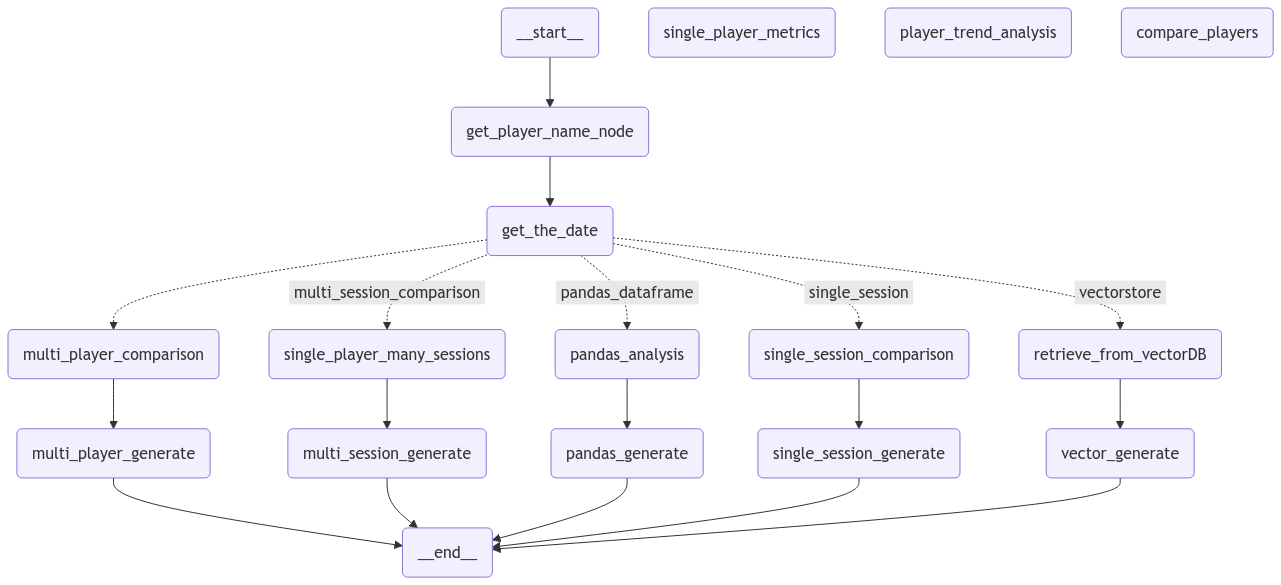

In [86]:


try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # # This requires some extra dependencies and is optional
    pass


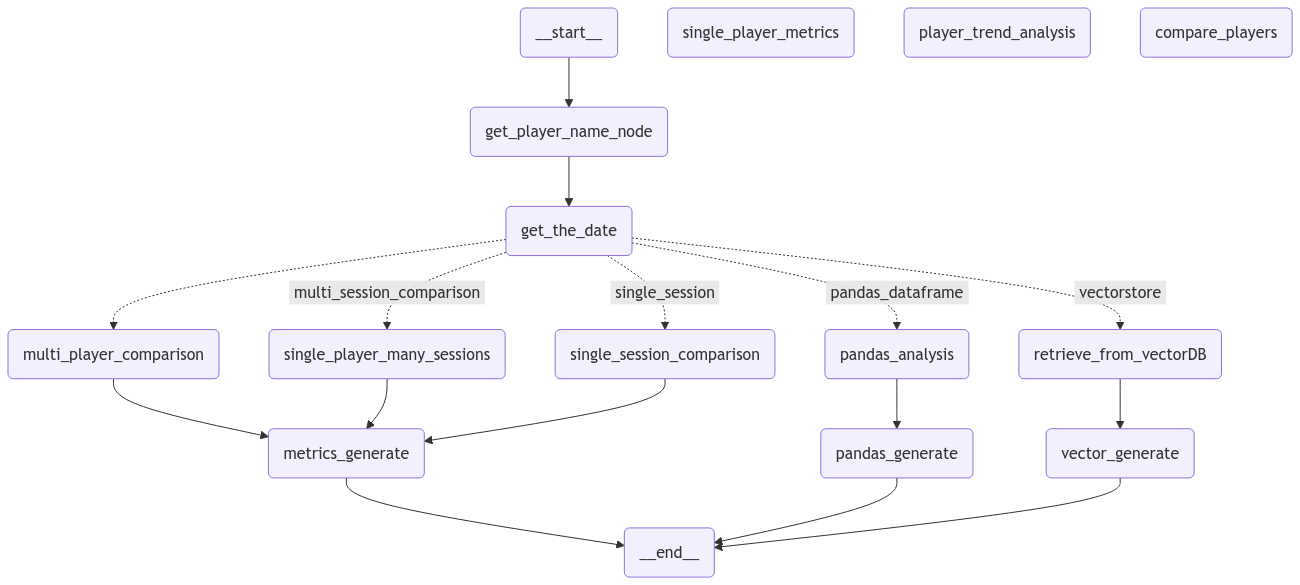

In [26]:
# workflow = StateGraph(State)

# # Add all nodes
# workflow.add_node("retrieve_from_vectorDB", retrieve_node)
# workflow.add_node("vector_generate", vector_generate_node)
# workflow.add_node("get_player_name_node", extract_name_node)
# workflow.add_node("get_the_date", extract_date_node)
# workflow.add_node("metrics_generate", metrics_generate_node)
# workflow.add_node("single_player_metrics", single_player_metrics_node)
# workflow.add_node("single_session_comparison", single_player_metrics_node)
# workflow.add_node("player_trend_analysis", single_player_multiple_sessions_node)
# workflow.add_node("single_player_many_sessions", single_player_multiple_sessions_node)
# workflow.add_node("compare_players", multi_player_comparison_node)
# workflow.add_node("multi_player_comparison", multi_player_comparison_node)
# workflow.add_node("pandas_analysis", pandas_agent_node)
# workflow.add_node("pandas_generate", pandas_generate_node)

# # Universal flow through name and date extraction
# workflow.add_edge(START, "get_player_name_node")
# workflow.add_edge("get_player_name_node", "get_the_date")

# # Route from date extraction based on datasource
# workflow.add_conditional_edges(
#     "get_the_date",
#     lambda x: x["datasource"],
#     {
#         "vectorstore": "retrieve_from_vectorDB",
#         "single_session": "single_session_comparison",
#         "multi_session_comparison": "single_player_many_sessions",
#         "multi_player_comparison": "multi_player_comparison",
#         "pandas_dataframe": "pandas_analysis"
#     }
# )

# # Generate nodes connections
# workflow.add_edge("retrieve_from_vectorDB", "vector_generate")
# workflow.add_edge("vector_generate", END)

# workflow.add_edge("single_session_comparison", "metrics_generate")
# workflow.add_edge("multi_player_comparison", "metrics_generate")
# workflow.add_edge("single_player_many_sessions", "metrics_generate")
# workflow.add_edge("metrics_generate", END)

# workflow.add_edge("pandas_analysis", "pandas_generate")
# workflow.add_edge("pandas_generate", END)

# # Compile the workflow
# app = workflow.compile()
# from IPython.display import Image, display

# try:
#     display(Image(app.get_graph().draw_mermaid_png()))
# except Exception:
#     # # This requires some extra dependencies and is optional
#     pass


In [93]:
from pprint import pprint
# Test questions for different paths 
test_questions = [
    # Vectorstore path
    "What is the one biggest factor contributing to injury according to the research?",
    # # Single session path 
    "Tell me about Lee?",
    # # Multi-session comparison path
    "Has Lee's workload increased over the past month?",
    # # Multi-player comparison path  
    "Compare the performance metrics between Lee and Fionn",
    # Pandas dataframe path
    "What's the average training duration across all players?"
]

# Run tests
for question in test_questions:
    print(f"\n=== TESTING QUESTION: {question} ===\n")
    
    # Use proper state initialization
    inputs = setup_initial_state(question)
    print(f"Here are the inputs : {inputs}")
    
    print("--- EXECUTION FLOW ---")
    try:
        for output in app.stream(inputs):
            print("Node inputs : ")
            print(inputs)
            print("\nNode Output:")
            for key, value in output.items():
                print(f"\nNode '{key}':")
                pprint(value)
                print(f"------------------------------ ANSWER BELOW-----------------------------------")
                print(value['answer'])
                print(f"------------------------------ ANSWER ABOVE-----------------------------------")
            print("\n---\n")
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        continue
        
    print("\n=== FINAL OUTPUT ===")
    if 'value' in locals():
        pprint(value)
    print("\n" + "="*50 + "\n")


=== TESTING QUESTION: What is the one biggest factor contributing to injury according to the research? ===

Here are the inputs : {'context': 'What is the one biggest factor contributing to injury according to the research?', 'datasource': 'vectorstore', 'player_name': None, 'date_info': None, 'player_metrics': {}, 'analysis_results': {}, 'vector_results': [], 'answer': ''}
--- EXECUTION FLOW ---
===========================================None==========================
Node inputs : 
{'context': 'What is the one biggest factor contributing to injury according to the research?', 'datasource': 'vectorstore', 'player_name': None, 'date_info': None, 'player_metrics': {}, 'analysis_results': {}, 'vector_results': [], 'answer': ''}

Node Output:

Node 'get_player_name_node':
{'analysis_results': {},
 'answer': '',
 'context': 'What is the one biggest factor contributing to injury according '
            'to the research?',
 'datasource': 'vectorstore',
 'date_info': None,
 'player_metrics':

In [88]:
print(value['answer'])

**Summary of Research Findings: High-Intensity Activity Metrics and Injury Risk in Professional Athletes**

### Key Research Findings

1. **Relationship between high-intensity activity metrics and injury risk**: The study found a significant correlation between high-intensity activity metrics, such as acceleration, deceleration, and sprint patterns, and injury risk in professional athletes.
2. **Importance of metabolic power and dynamic stress load (DSL) measurements**: The research highlighted the critical role of metabolic power and DSL measurements in identifying early warning indicators of potential injuries and recovery patterns.
3. **Recovery patterns and injury prevention**: The study showed that successful injury prevention was associated with specific recovery patterns, including active recovery metrics and return-to-play indicators.

### Important Thresholds and Metrics

1. **Dynamic Stress Load (DSL)**: DSL accumulation patterns, magnitude/intensity coupling, and metabolic p

In [29]:
####################### I dont think having just one generate metrics node is best #################################